In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date

Preprocess

In [2]:
total = pd.read_csv("https://raw.githubusercontent.com/lavibula/ML20222.PredictionBitcoin/main/working/Data_working.csv")
#cac gia tri row > 4658 duoc xoa -> NULL
total = total.loc[:4658,:] 
#dien cac gia tri con thieu
total = total.fillna(method='ffill')
for index in total.index:
  total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%d/%m/%Y').date()
print(total.head())


         Date  BTC_close  BTC_open  BTC_high  BTC_low  BTC_volume   
0  2023-04-16    30310.3   30299.2   30545.3  30134.6       34.48  \
1  2023-04-15    30299.6   30472.6   30586.5  30208.8       31.71   
2  2023-04-14    30472.5   30387.4   30964.9  30026.0       98.38   
3  2023-04-13    30387.4   29892.4   30524.1  29864.5       65.87   
4  2023-04-12    29886.4   30209.8   30473.0  29679.5       78.69   

   Active_Addr_Cnt    Difficulty  Mean_Block_Size(in_bytes)  Sum_Block_Weight   
0         840992.0  4.788780e+13                1866594.290       495223185.0  \
1        1045660.0  4.788780e+13                1839875.354       631025193.0   
2        1016042.0  4.788780e+13                1759535.436       559166432.0   
3        1009669.0  4.788780e+13                1812112.549       567094231.0   
4        1056542.0  4.788780e+13                1933495.919       635037442.0   

   ...      ETH     LTC      DOGE      XRP    GOLD  SILVER  COOPER   S&P500   
0  ...  2119.29  10

In [3]:
#ETH ra doi ngay 30/7/2015, random 1 date sau do
#Biểu đồ giá đóng cửa Bitcoin (BTC) cho thấy một mô hình tương đối bằng phẳng trong dữ liệu từ tháng 9 năm 2014 đến tháng 7 năm 2016, 
#sau đó là đợt tăng giá mạnh từ tháng 9 năm 2017 đến tháng 1 năm 2018
Start_day = date(2015, 9, 1)
Test_day = date(2018,6,30)
#chon ra 20-25% data trong giai doan 1
End_day = date(2018,9,30)
# train, test
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day) ].reset_index(drop = True)
train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)
print(test_dataset.head())
print(test_dataset.tail())

         Date  BTC_close  BTC_open  BTC_high  BTC_low  BTC_volume   
0  2018-09-30     6635.2    6603.9    6673.9   6533.5        9.34  \
1  2018-09-29     6603.9    6633.9    6648.4   6464.4        9.42   
2  2018-09-28     6636.0    6685.7    6809.2   6538.6        9.57   
3  2018-09-27     6689.2    6463.7    6738.3   6428.8        9.34   
4  2018-09-26     6468.1    6443.0    6551.9   6384.1        8.64   

   Active_Addr_Cnt    Difficulty  Mean_Block_Size(in_bytes)  Sum_Block_Weight   
0         514766.0  7.152630e+12                610653.1472       330287157.0  \
1         564628.0  7.152630e+12                709309.6184       355787307.0   
2         654875.0  7.152630e+12                835734.5195       422560874.0   
3         642476.0  7.152630e+12                887769.7133       414744804.0   
4         624467.0  7.152630e+12                894936.2086       406826648.0   

   ...     ETH     LTC      DOGE      XRP    GOLD  SILVER   COOPER   S&P500   
0  ...  232.80  61.

In [4]:
X_train = train_dataset.drop(["Date"], axis=1)[:-1]
Y_train = train_dataset["BTC_close"][1:]

X_test = test_dataset.drop(["Date"], axis=1)[:-1]
Y_test = test_dataset["BTC_close"][1:]

Model

In [5]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [6]:
simpleTree = RandomForestRegressor(max_depth=15, n_estimators=500)
#Xây dựng cây hồi quy với độ sâu cây là 10 (Random forest), 500 cây
simpleTree.fit(X_train, Y_train)

RandomForestRegressor(max_depth=15, n_estimators=500)

In [7]:
# Importance of variables
features = X_train.columns
importances = simpleTree.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(14,14))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.title("Variables Ranks in Period 1")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
#so sanh cac gia tri du doan va quan sat
Y_pred = simpleTree.predict(X_test)
#hien thi ket qua du doan
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(Y_test, color = 'red', label="Bitcoin Price")
ax.plot(Y_pred, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
plt.title("Random Forest Regression for Period 1")
plt.legend()
plt.show()

In [ ]:
#tinh toan loi du doan
#RMSE
from sklearn.metrics import mean_squared_error
print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print()

#MAPE
MAPE = np.average(np.abs((Y_test.values - Y_pred) / Y_test.values))
print("MAPE:", MAPE)
print()

#DA
Y_test_DA = np.array(Y_test)
Y_pred_0 = Y_pred[1:] - Y_test_DA[:-1]
Y_test_0 = Y_test[1:] - Y_test_DA[:-1]
DA = (Y_pred_0<0) == (Y_test_0<0)
print("DA accuracy:", f"{round(np.mean(DA)*100, 2)}%")

In [10]:
n_jobs = -1

In [15]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=750, n_jobs=n_jobs, random_state=42)
forest.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=750, n_jobs=-1, random_state=42)

In [33]:
import time
import matplotlib.pyplot as plt

start_time = time.time()
features = X_train.columns
importances = simpleTree.feature_importances_
indices = np.argsort(importances)
importances = forest.feature_importances_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


Elapsed time to compute the importances: 0.135 seconds


In [43]:
total_without_date = total.drop('Date', axis=1)
total_without_date 

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COOPER,S&P500,DJI,JP225
0,6635.2,6603.9,6673.9,6533.5,9.34,514766.0,7.152630e+12,610653.1472,330287157.0,99520.287158,...,232.80,61.224,0.005933,0.58274,1191.7,14.507,6238.25,2924.59,26651.21,24245.76
1,6603.9,6633.9,6648.4,6464.4,9.42,564628.0,7.152630e+12,709309.6184,355787307.0,127738.469224,...,231.87,61.703,0.005887,0.56983,1191.7,14.507,6238.25,2924.59,26651.21,24245.76
2,6636.0,6685.7,6809.2,6538.6,9.57,654875.0,7.152630e+12,835734.5195,422560874.0,187283.450000,...,221.77,61.947,0.005894,0.53969,1196.2,14.712,6258.75,2913.98,26458.31,24120.04
3,6689.2,6463.7,6738.3,6428.8,9.34,642476.0,7.152630e+12,887769.7133,414744804.0,161349.421224,...,229.15,63.267,0.005890,0.54315,1187.4,14.290,6178.25,2914.00,26439.93,23796.74
4,6468.1,6443.0,6551.9,6384.1,8.64,624467.0,7.152630e+12,894936.2086,406826648.0,128082.647154,...,214.35,57.259,0.005776,0.51257,1199.1,14.354,6288.75,2905.97,26385.28,24033.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,233.7,230.3,235.6,228.3,48.28,323127.0,5.695765e+10,458669.2313,269697508.0,6732.711193,...,11.75,3.840,0.003213,0.00800,1121.0,14.755,5135.00,1969.41,16492.68,17860.47
1122,230.3,226.2,231.1,225.8,61.76,260465.0,5.602268e+10,350699.4231,218836440.0,5724.305851,...,11.75,3.840,0.003213,0.00954,1121.4,14.544,5105.00,1921.22,16102.38,17792.16
1123,226.2,228.6,229.6,225.4,54.15,297285.0,5.425663e+10,477061.6918,278604028.0,6084.855902,...,11.75,3.840,0.003213,0.00954,1124.5,14.702,5220.00,1951.13,16374.76,18182.39
1124,228.6,227.2,230.6,225.6,58.77,292511.0,5.425663e+10,767255.8438,491043740.0,12555.486691,...,11.75,3.840,0.003213,0.00871,1133.6,14.664,5115.00,1948.86,16351.38,18095.40


In [44]:
total_without_date.corr()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COOPER,S&P500,DJI,JP225
BTC_close,1.000000,0.997117,0.998958,0.998328,0.498706,0.685822,0.650128,0.408219,0.264172,0.660058,...,0.916529,0.951100,0.488705,0.847978,0.419664,-0.073547,0.827061,0.830017,0.859851,0.840533
BTC_open,0.997117,1.000000,0.998675,0.997307,0.505230,0.682619,0.652230,0.406264,0.261032,0.664212,...,0.918919,0.952920,0.493275,0.850951,0.420761,-0.072954,0.827176,0.830726,0.860446,0.841037
BTC_high,0.998958,0.998675,1.000000,0.997246,0.509216,0.689389,0.642213,0.411540,0.269125,0.671438,...,0.916686,0.952960,0.491926,0.848933,0.419716,-0.071644,0.825078,0.825668,0.856029,0.837737
BTC_low,0.998328,0.997307,0.997246,1.000000,0.488685,0.674945,0.666984,0.400877,0.251173,0.641307,...,0.919407,0.950474,0.485828,0.849029,0.421344,-0.076459,0.831500,0.839205,0.868046,0.846937
BTC_volume,0.498706,0.505230,0.509216,0.488685,1.000000,0.336735,0.330344,0.223558,0.152495,0.208724,...,0.571106,0.529313,0.106014,0.448370,0.223378,-0.097640,0.490063,0.435214,0.456722,0.467133
Active_Addr_Cnt,0.685822,0.682619,0.689389,0.674945,0.336735,1.000000,0.213120,0.805098,0.821611,0.649883,...,0.602900,0.615929,0.266732,0.562203,0.396992,0.183903,0.673084,0.611928,0.636278,0.588347
Difficulty,0.650128,0.652230,0.642213,0.666984,0.330344,0.213120,1.000000,0.097893,-0.154333,0.062138,...,0.593017,0.542168,0.256695,0.521570,0.203003,-0.260174,0.587433,0.836126,0.820639,0.751865
Mean_Block_Size(in_bytes),0.408219,0.406264,0.411540,0.400877,0.223558,0.805098,0.097893,1.000000,0.830302,0.396942,...,0.383079,0.352384,0.142828,0.332711,0.411603,0.328469,0.480524,0.449967,0.459880,0.345957
Sum_Block_Weight,0.264172,0.261032,0.269125,0.251173,0.152495,0.821611,-0.154333,0.830302,1.000000,0.392564,...,0.253319,0.240486,0.110319,0.230523,0.308972,0.332515,0.335542,0.244517,0.259383,0.184110
Total_Fees(USD),0.660058,0.664212,0.671438,0.641307,0.208724,0.649883,0.062138,0.396942,0.392564,1.000000,...,0.521935,0.668052,0.517645,0.610938,0.202475,0.037419,0.422333,0.329204,0.363222,0.413248


<Axes: >

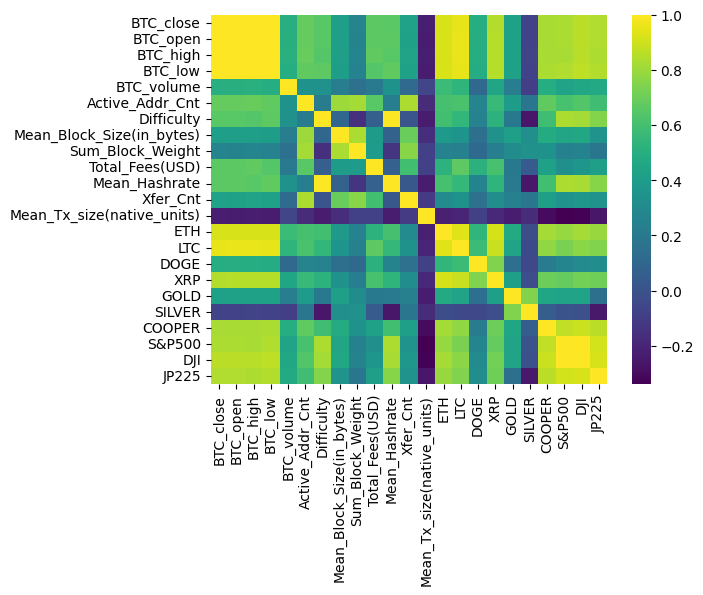

In [74]:
import seaborn as sns
#sns.heatmap(total_without_date.corr(), cmap="viridis")
#sns.heatmap(total_without_date.corr(), cmap="plasma")
#sns.heatmap(total_without_date.corr(), cmap="inferno")
#sns.heatmap(total_without_date.corr(), cmap="magma")
#sns.heatmap(total_without_date.corr(), cmap="cividis")
#sns.heatmap(total_without_date.corr(), cmap="RdBu")
sns.heatmap(total_without_date.corr(), cmap="YlGnBu")
#sns.heatmap(total_without_date.corr(), cmap="YlOrBr")
